In [1]:
from cenpy import products, explorer, tiger
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
import pandas as pd

C:\Users\blake\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import statsmodels.api as sm
import numpy as np
import re
from sklearn.model_selection import train_test_split
from statsmodels import tools

In [3]:
df = pd.read_csv('TTS_LBNL_public_file_27-Oct-2023_all.csv')

C:\Users\blake\AppData\Local\Temp\ipykernel_67892\2929198088.py:1: DtypeWarning: Columns (1,2,3,8,11,15,16,18,20,28,29,31,32,34,35,38,39,40,53,54,56,57,59,60,74,75,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('TTS_LBNL_public_file_27-Oct-2023_all.csv')


In [4]:
CA = df[df['state'] == 'CA']

In [5]:
CA['year'] = CA['installation_date'].str.extract(r"-(\d{4})")
CA['year'] = CA['year'].dropna(0).astype(int)
CA = CA[CA['year'] < 2018]
CA = CA[CA['customer_segment'] == 'RES']


C:\Users\blake\AppData\Local\Temp\ipykernel_67892\1107238570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA['year'] = CA['installation_date'].str.extract(r"-(\d{4})")
C:\Users\blake\AppData\Local\Temp\ipykernel_67892\1107238570.py:2: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  CA['year'] = CA['year'].dropna(0).astype(int)
C:\Users\blake\AppData\Local\Temp\ipykernel_67892\1107238570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA['year'] 

In [92]:
counts = CA.groupby('zip_code').count().iloc[:,0]
counts = counts.reset_index()
counts = counts.rename(columns={'data_provider_1':'installed'})

In [93]:
counts

,zip_code,installed
0,-1,260
1,0,18
2,831,1
3,2399,1
4,9327,1
...,...,...
2429,96094,29
2430,96097,19
2431,96101,6
2432,96104,4


In [6]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [95]:
conn = products.APIConnection("ACSDT5Y2017")
data = conn.query(cols=['B25003_002E','B19301_001E','B25003_001E','B25040_004E','B25040_008E','B25077_001E'], geo_unit = 'zip code tabulation area')

In [96]:
data = data[data['state'] == '06']
data['zip'] = data['zip code tabulation area']
#data = data[data['zip'].isin(codes)]
data['B25003_002E'] = data['B25003_002E'].astype(int)
#data['B19301_001E'] = data['B19301_001E'].astype(int)
data['B25003_001E'] = data['B25003_001E'].astype(int)
data['B25040_004E'] = data['B25040_004E'].astype(int)
data['B25040_008E'] = data['B25040_008E'].astype(int)
data['B25077_001E'] = data['B25077_001E'].astype(int)

final = pd.DataFrame()
final['zip'] = data['zip']
final['total'] = data['B25003_001E']
final['owner_occupied_%'] = 100*data['B25003_002E']/final['total']
final['electric_heated_%'] = 100*data['B25040_004E']/final['total']
final['solar_heated_%'] = 100*data['B25040_008E']/final['total']
final['income'] = data['B19301_001E']
final['home_value'] = data['B25077_001E']
final = final.merge(counts,how='left', left_on='zip', right_on='zip_code')
final = final.dropna(0)
final['zip'] = final['zip'].astype(int)
final['income'] = final['income'].astype(int)
final['nerds'] = (final['electric_heated_%'] > 20).astype(int)
final

train, test = train_test_split(final, train_size=0.75, random_state=1)

C:\Users\blake\AppData\Local\Temp\ipykernel_72020\3292441505.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  final = final.dropna(0)


In [97]:
##### OUTLIER CLEANING
#train = train[train['installed'] > 1]
#train = train[train['total'] > 10000]

In [98]:
features = ['total','owner_occupied_%','income']
model = fit_OLS_model(train, 'installed', features)

In [99]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              installed   R-squared (uncentered):                   0.351
Model:                            OLS   Adj. R-squared (uncentered):              0.339
Method:                 Least Squares   F-statistic:                              30.60
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                    7.22e-16
Time:                        12:43:29   Log-Likelihood:                         -1163.9
No. Observations:                 173   AIC:                                      2334.
Df Residuals:                     170   BIC:                                      2343.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

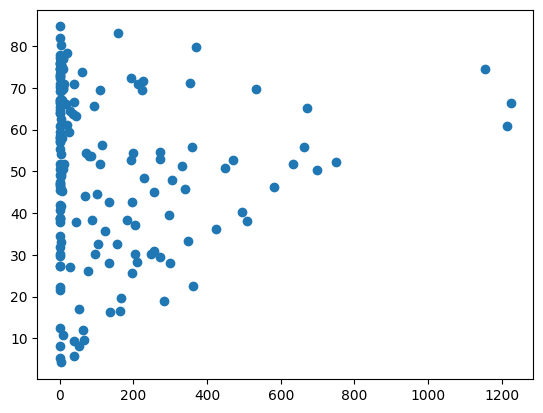

In [100]:
plt.scatter(train['installed'],train['owner_occupied_%'])

In [101]:
y = test['installed']
X = test[features]
y_pred = model.predict(X)
tools.eval_measures.rmse(y, y_pred, axis=0)

175.89374612561102

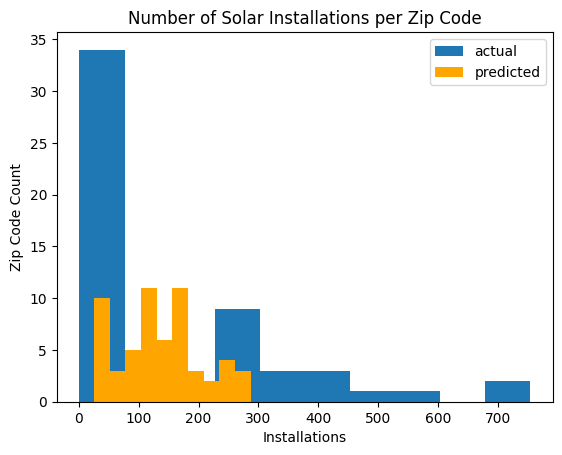

In [103]:
plt.hist(y,label='actual')
plt.hist(y_pred,color='orange', label='predicted')
plt.title('Number of Solar Installations per Zip Code')
plt.xlabel('Installations')
plt.ylabel('Zip Code Count')
plt.legend()

# Cluster Analysis

In [130]:
oakland_tenure = products.ACS(2019).from_place('San Jose, CA',level='tract',
                                        variables=['B25003'])
oakland_tenure = oakland_tenure.rename(columns={'B25003_002E':'Owner Occupied', 'B25003_003E':'Renter Occupied','B25003_001E':'Total',})

Matched: San Jose, CA to San Jose city within layer Incorporated Places


C:\Users\blake\AppData\Local\Temp\ipykernel_81636\2788953194.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  oakland_tenure = products.ACS(2019).from_place('San Jose, CA',level='tract',


In [131]:
oakland_income = products.ACS(2019).from_place('San Jose, CA',level='tract',
                                        variables=['B19301'])
oakland_income = oakland_income.rename(columns={'B19301_001E':'Estimated Per Capita Income Past 12 Months'})

Matched: San Jose, CA to San Jose city within layer Incorporated Places


C:\Users\blake\AppData\Local\Temp\ipykernel_81636\2049368102.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  oakland_income = products.ACS(2019).from_place('San Jose, CA',level='tract',


In [132]:
oakland_test = pd.DataFrame()
oakland_test['total'] = oakland_tenure['Total']
oakland_test['owner_occupied_%'] = 100*oakland_tenure['Owner Occupied']/oakland_test['total']
oakland_test['income'] = oakland_income['Estimated Per Capita Income Past 12 Months']
oak_pred = model.predict(oakland_test)
oakland_tenure['installed_pred'] = oak_pred

Text(0.5, 1.0, 'OLS Predictions for # of Rooftop Solar Installations')

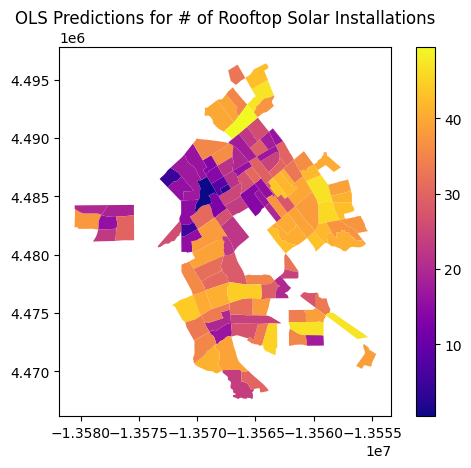

In [133]:
oakland_tenure.plot('installed_pred', cmap='plasma',legend=True)
plt.title('OLS Predictions for # of Rooftop Solar Installations')

In [134]:
oakland_tenure['pct_rent']=(oakland_tenure['Renter Occupied']/oakland_tenure['Total'])*100
full_df = oakland_tenure.join(oakland_income, lsuffix='', rsuffix='_inc')
full_df.columns

Index(['GEOID', 'geometry', 'B25003A_001E', 'B25003A_002E', 'B25003A_003E',
       'B25003B_001E', 'B25003B_002E', 'B25003B_003E', 'B25003C_001E',
       'B25003C_002E', 'B25003C_003E', 'B25003D_001E', 'B25003D_002E',
       'B25003D_003E', 'B25003E_001E', 'B25003E_002E', 'B25003E_003E',
       'B25003F_001E', 'B25003F_002E', 'B25003F_003E', 'B25003G_001E',
       'B25003G_002E', 'B25003G_003E', 'B25003H_001E', 'B25003H_002E',
       'B25003H_003E', 'B25003I_001E', 'B25003I_002E', 'B25003I_003E', 'Total',
       'Owner Occupied', 'Renter Occupied', 'state', 'county', 'tract',
       'installed_pred', 'pct_rent', 'GEOID_inc', 'geometry_inc',
       'B19301A_001E', 'B19301B_001E', 'B19301C_001E', 'B19301D_001E',
       'B19301E_001E', 'B19301F_001E', 'B19301G_001E', 'B19301H_001E',
       'B19301I_001E', 'Estimated Per Capita Income Past 12 Months',
       'state_inc', 'county_inc', 'tract_inc'],
      dtype='object')

In [135]:
k3 = KMeans(n_clusters=3)
cluster_variables = ['pct_rent','Estimated Per Capita Income Past 12 Months','Total','installed_pred']
baka = k3.fit(full_df[cluster_variables])

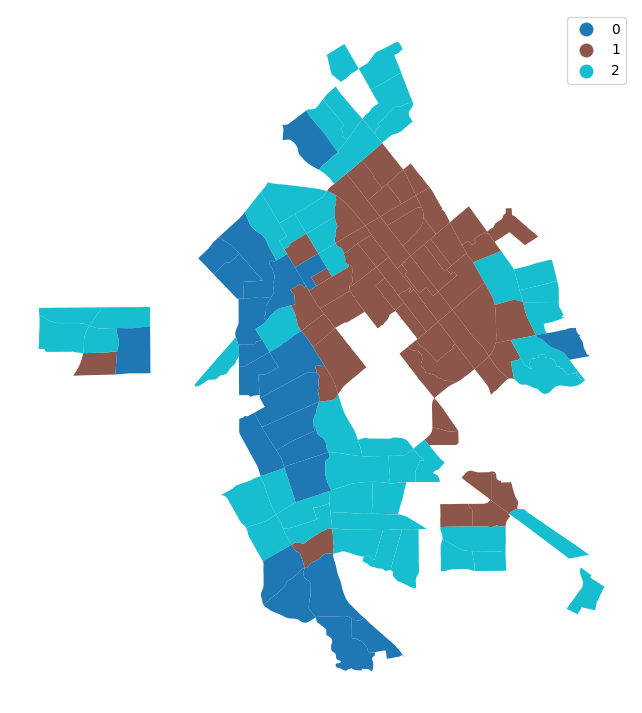

In [136]:
full_df['baka'] = baka.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
full_df.plot(
    column='baka', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [137]:
newk3 = KMeans(n_clusters=3)
varss = ['pct_rent','Estimated Per Capita Income Past 12 Months','Total']
raw = newk3.fit(full_df[varss])

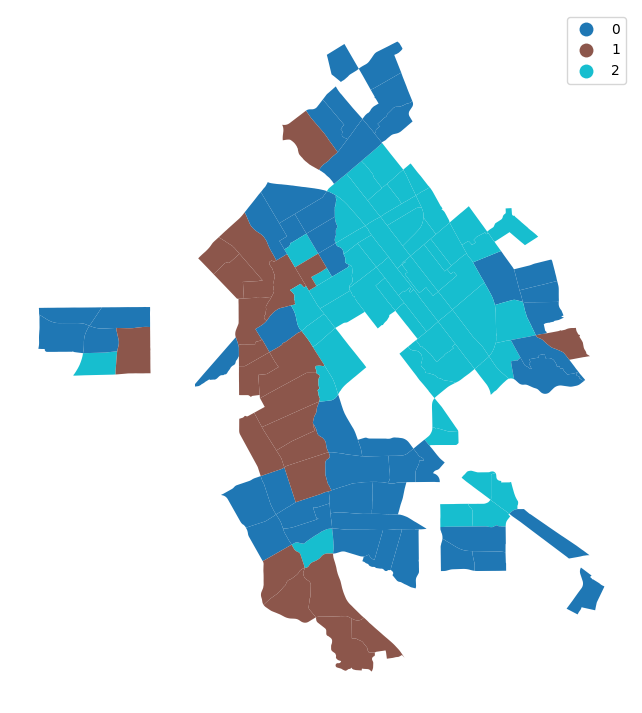

In [138]:
full_df['raw'] = raw.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
full_df.plot(
    column='raw', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [139]:
k3 = full_df.groupby('baka')[cluster_variables].mean()
k3.T.round(2)

baka,0,1,2
pct_rent,35.27,54.68,38.79
Estimated Per Capita Income Past 12 Months,72016.36,25665.21,46638.00
Total,1804.50,1279.19,1707.93
installed_pred,26.08,28.50,33.42


In [140]:
k3 = full_df.groupby('raw')[varss].mean()
k3.T.round(2)

raw,0,1,2
pct_rent,38.79,35.27,54.68
Estimated Per Capita Income Past 12 Months,46638.00,72016.36,25665.21
Total,1707.93,1804.50,1279.19


Text(0.5, 1.0, 'Cluster 2')

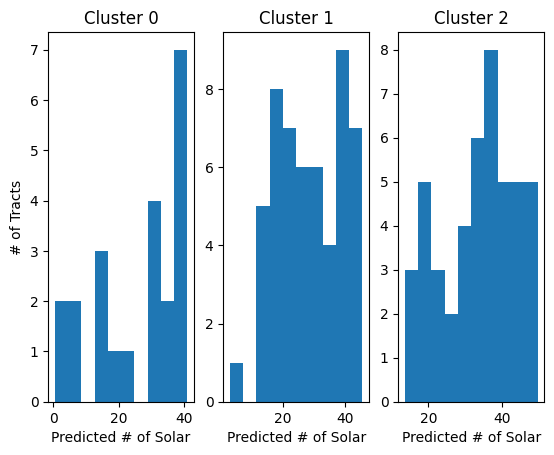

In [141]:
plt.subplot(1,3,1)
plt.hist(full_df[full_df['baka']==0]['installed_pred'])
plt.title("Cluster 0")
plt.ylabel('# of Tracts')
plt.xlabel('Predicted # of Solar')
plt.subplot(1,3,2)
plt.hist(full_df[full_df['baka']==1]['installed_pred'])
plt.xlabel('Predicted # of Solar')
plt.title("Cluster 1")
plt.subplot(1,3,3)
plt.hist(full_df[full_df['baka']==2]['installed_pred'])
plt.xlabel('Predicted # of Solar')
plt.title("Cluster 2")

Text(0.5, 1.0, 'Cluster 2')

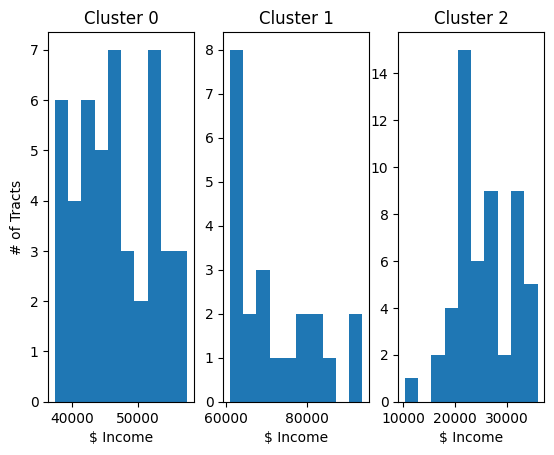

In [142]:
plt.subplot(1,3,1)
plt.hist(full_df[full_df['raw']==0]['Estimated Per Capita Income Past 12 Months'])
plt.title("Cluster 0")
plt.ylabel('# of Tracts')
plt.xlabel('$ Income')
plt.subplot(1,3,2)
plt.hist(full_df[full_df['raw']==1]['Estimated Per Capita Income Past 12 Months'])
plt.xlabel('$ Income')
plt.title("Cluster 1")
plt.subplot(1,3,3)
plt.hist(full_df[full_df['raw']==2]['Estimated Per Capita Income Past 12 Months'])
plt.xlabel('$ Income')
plt.title("Cluster 2")

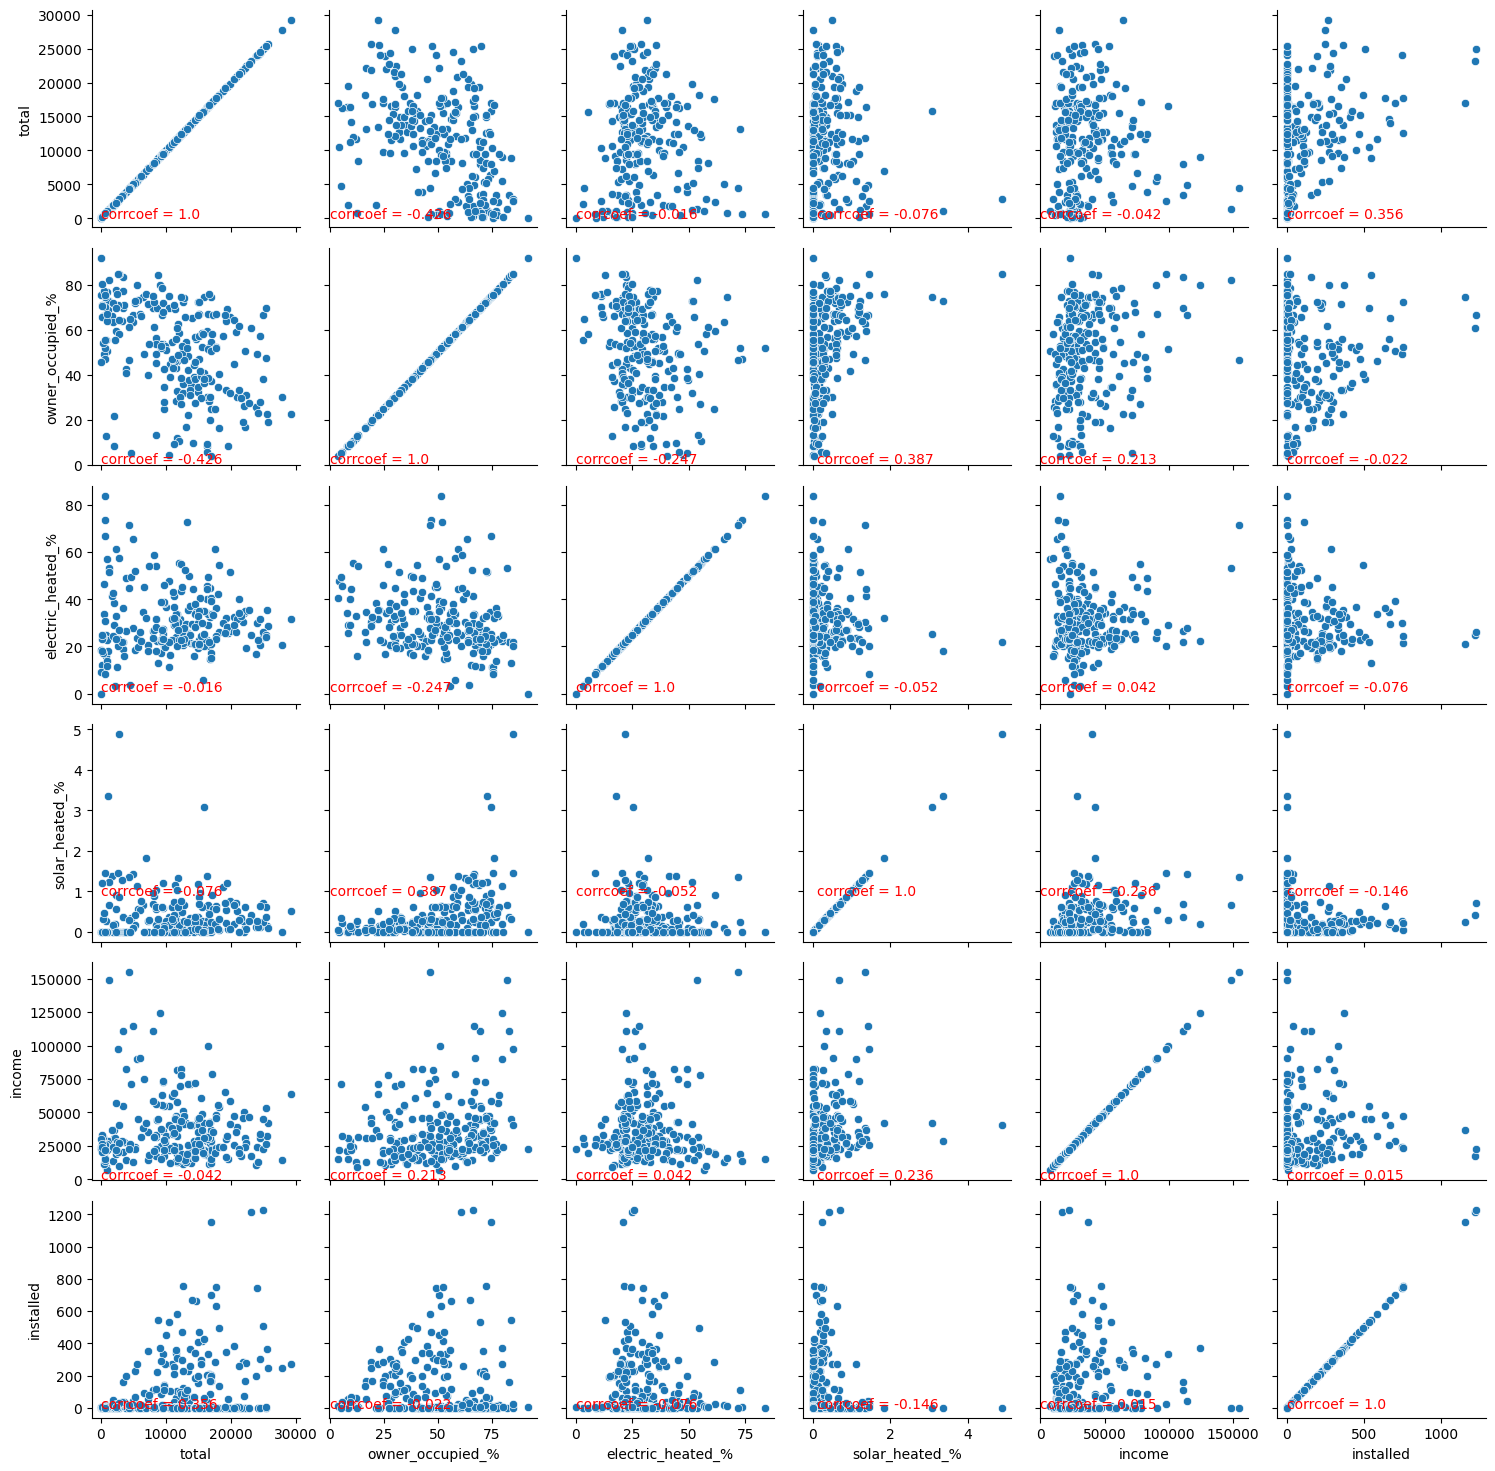

In [156]:
grid = sns.PairGrid(final[['total','owner_occupied_%','electric_heated_%','solar_heated_%','income','installed']]) 
grid.map(sns.scatterplot)


def corrfunc(x, y, **kws):
    r = np.round(np.corrcoef(x, y)[0][1], 3)
    ax = plt.gca()
    ax.annotate(f'corrcoef = {r}',
                xy=(.1, .9), color='Red')
grid.map(corrfunc)



# New Dataset Model

In [7]:
newd = pd.read_csv('newsolar.csv',encoding = "utf-8")
newd = newd.fillna(0)
newd['total'] = newd['*'] + newd['Imperial Irr. District'] + newd['Palo Alto Utilities'] + newd['PG&E'] + newd['SCE'] + newd['SDG&E'] + newd['SMUD']

Text(0, 0.5, 'Number of Tracts')

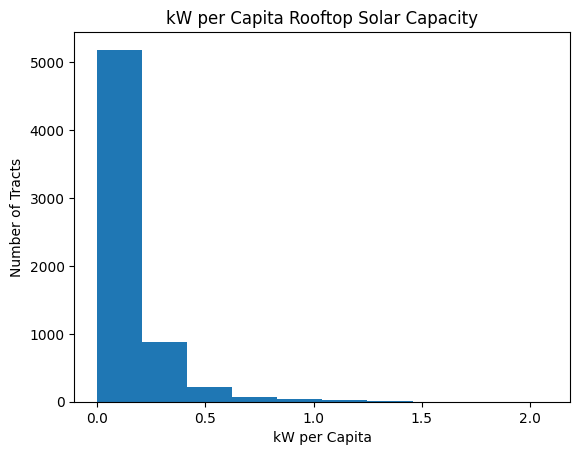

In [40]:
newd['Utility Service Territory'] = newd['Utility Service Territory'].astype(str)
newd['GEOID'] = newd['Utility Service Territory'].astype(str)
plt.hist(newd['total'])
plt.title('kW per Capita Rooftop Solar Capacity')
plt.xlabel('kW per Capita')
plt.ylabel('Number of Tracts')

In [5]:
features = ['B25003_002E','B19301_001E','B25003_001E','B25040_004E','B25040_008E','B25077_001E']
counties = ['Alameda','Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings','Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']

In [108]:
whole_state = pd.DataFrame()
for i in counties:
    i += ', CA'
    count = products.ACS(2019).from_county(i,level='tract',
                                        variables=features)
    whole_state = pd.concat([whole_state, count])

C:\Users\blake\AppData\Local\Programs\Python\Python311\Lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)
C:\Users\blake\AppData\Local\Programs\Python\Python311\Lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)
C:\Users\blake\AppData\Local\Programs\Python\Python311\Lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county, variables, level, "Counties", **kwargs)
C:\Users\blake\AppData\Local\Programs\Python\Python311\Lib\site-packages\cenpy\products.

In [110]:
whole_state.to_csv('whole_state1.csv')

In [111]:
whole_state['GEOID'] = whole_state['GEOID'].str.slice(start=1)
whole_state['GEOID'] = whole_state['GEOID'].astype(str)

,geometry,B19301_001E,B25003_001E,B25003_002E,B25040_004E,B25040_008E,B25077_001E,NAME,state,county,tract
GEOID,,,,,,,,,,,
6001443321,"POLYGON ((-13573121.840 4507617.670, -13573118...",53567.0,1125.0,471.0,411.0,0.0,677000.0,"Census Tract 4433.21, Alameda County, California",06,001,443321
6001425104,"POLYGON ((-13613398.680 4556103.530, -13613358...",53354.0,1958.0,626.0,936.0,0.0,528000.0,"Census Tract 4251.04, Alameda County, California",06,001,425104
6001421800,"POLYGON ((-13612511.680 4562618.280, -13612503...",68460.0,859.0,574.0,113.0,5.0,983800.0,"Census Tract 4218, Alameda County, California",06,001,421800
6001422300,"POLYGON ((-13612458.250 4562016.630, -13612437...",59987.0,1680.0,633.0,342.0,20.0,948200.0,"Census Tract 4223, Alameda County, California",06,001,422300
6001421200,"POLYGON ((-13612816.590 4565165.880, -13612811...",112939.0,1466.0,1328.0,107.0,6.0,1406500.0,"Census Tract 4212, Alameda County, California",06,001,421200
...,...,...,...,...,...,...,...,...,...,...,...
6115040500,"POLYGON ((-13532343.950 4737885.580, -13532316...",16856.0,1270.0,583.0,340.0,27.0,156800.0,"Census Tract 405, Yuba County, California",06,115,040500
6115040100,"POLYGON ((-13538195.010 4745784.450, -13538179...",23722.0,1960.0,497.0,743.0,18.0,181300.0,"Census Tract 401, Yuba County, California",06,115,040100
6115040400,"POLYGON ((-13536965.380 4737842.830, -13536963...",13743.0,1791.0,622.0,591.0,24.0,166400.0,"Census Tract 404, Yuba County, California",06,115,040400


In [112]:
whole_state = whole_state[whole_state['GEOID'].isin(newd['Utility Service Territory'])]

In [135]:
joined = newd.set_index("GEOID").join(whole_state.set_index("GEOID"), on='GEOID', how='left')


# Setting the Model

In [9]:
data = pd.read_csv('whole_state1.csv')

In [10]:
#### Data Cleaning
data.fillna(0)
data['GEOID'] = data['GEOID'].astype(str)
joined = newd.set_index("GEOID").join(data.set_index("GEOID"), on='GEOID', how='left', lsuffix='~')
joined

,Unnamed: 0~,Utility Service Territory,*,Imperial Irr. District,Palo Alto Utilities,PG&E,SCE,SDG&E,SMUD,total,...,B19301_001E,B25003_001E,B25003_002E,B25040_004E,B25040_008E,B25077_001E,NAME,state,county,tract
GEOID,,,,,,,,,,,,,,,,,,,,,
6001400100,Census Tract,6001400100,0.0,0.0,0.0,0.242,0.0,0.0,0.0,0.242,...,116300.0,1293.0,1150.0,153.0,0.0,1197900.0,"Census Tract 4001, Alameda County, California",6,1,400100
6001400200,Census Tract,6001400200,0.0,0.0,0.0,0.122,0.0,0.0,0.0,0.122,...,90742.0,847.0,525.0,115.0,8.0,1385400.0,"Census Tract 4002, Alameda County, California",6,1,400200
6001400300,Census Tract,6001400300,0.0,0.0,0.0,0.081,0.0,0.0,0.0,0.081,...,80071.0,2441.0,1014.0,596.0,7.0,1053200.0,"Census Tract 4003, Alameda County, California",6,1,400300
6001400400,Census Tract,6001400400,0.0,0.0,0.0,0.085,0.0,0.0,0.0,0.085,...,69737.0,1802.0,738.0,316.0,0.0,1111600.0,"Census Tract 4004, Alameda County, California",6,1,400400
6001400500,Census Tract,6001400500,0.0,0.0,0.0,0.063,0.0,0.0,0.0,0.063,...,52438.0,1606.0,638.0,390.0,0.0,813800.0,"Census Tract 4005, Alameda County, California",6,1,400500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115040700,Census Tract,6115040700,0.0,0.0,0.0,0.434,0.0,0.0,0.0,0.434,...,29604.0,3917.0,3261.0,865.0,86.0,301200.0,"Census Tract 407, Yuba County, California",6,115,40700
6115040800,Census Tract,6115040800,0.0,0.0,0.0,0.252,0.0,0.0,0.0,0.252,...,37146.0,1719.0,1202.0,282.0,11.0,273300.0,"Census Tract 408, Yuba County, California",6,115,40800
6115040901,Census Tract,6115040901,0.0,0.0,0.0,0.388,0.0,0.0,0.0,0.388,...,26429.0,1038.0,770.0,232.0,18.0,222100.0,"Census Tract 409.01, Yuba County, California",6,115,40901


In [19]:
final = pd.DataFrame()
final['total'] = joined['B25003_001E']
final['owner_occupied_%'] = 100*joined['B25003_002E']/(final['total']+1)
final['electric_heated_%'] = 100*joined['B25040_004E']/(final['total']+1)
final['solar_heated_%'] = 100*joined['B25040_008E']/(final['total']+1)
final['income'] = joined['B19301_001E']
final['home_value'] = joined['B25077_001E']
final['kW per Capita'] = joined['total']

### drop only one row missing both income and home_value
final = final.drop('6037980004')

########## IMPUTATION METHOD - NAIVE (only applies to ~30-40 rows for home_value alone)
final = final.fillna(0)

In [20]:
train, test = train_test_split(final, train_size=0.75, random_state=1)

In [21]:
features = ['total','owner_occupied_%','electric_heated_%','solar_heated_%','income','home_value']
#features = ['owner_occupied_%','electric_heated_%','solar_heated_%','income','home_value']
model = fit_OLS_model(train, 'kW per Capita', features)

In [22]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          kW per Capita   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              1413.
Date:                Sat, 04 May 2024   Prob (F-statistic):                        0.00
Time:                        11:02:26   Log-Likelihood:                          3158.8
No. Observations:                4814   AIC:                                     -6306.
Df Residuals:                    4808   BIC:                                     -6267.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [15]:
y = test['kW per Capita']
X = test[features]
y_pred = model.predict(X)
tools.eval_measures.rmse(y, y_pred, axis=0)

0.12353941574821535

# Coefficient Math

In [31]:
np.quantile(newd['total'],0.75)

0.172

In [39]:
total_coef = 0.000001807
owner_coef = 0.0017
electric_coef = -0.0011
solar_coef = 0.0539
incom_coef = 0.000002924
home_coef = -0.0000001495

0.1/home_coef



-668896.3210702341

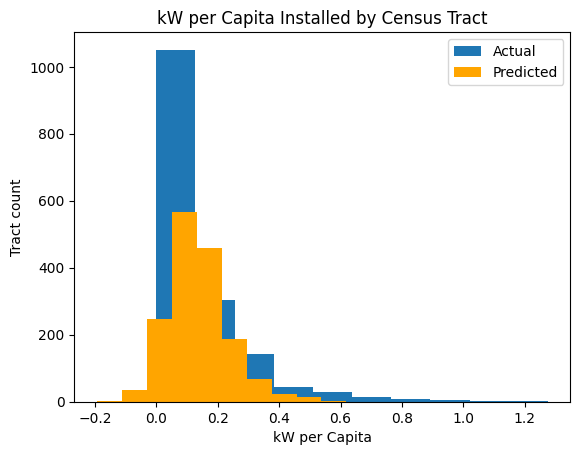

In [16]:
plt.hist(y, label='Actual')
plt.hist(y_pred, color='orange', label='Predicted')
plt.xlabel('kW per Capita')
plt.ylabel('Tract count')
plt.title('kW per Capita Installed by Census Tract')
plt.legend()

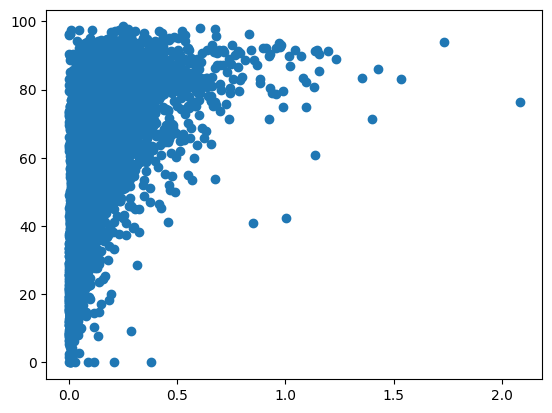

In [17]:
plt.scatter(train['kW per Capita'],train['owner_occupied_%'])

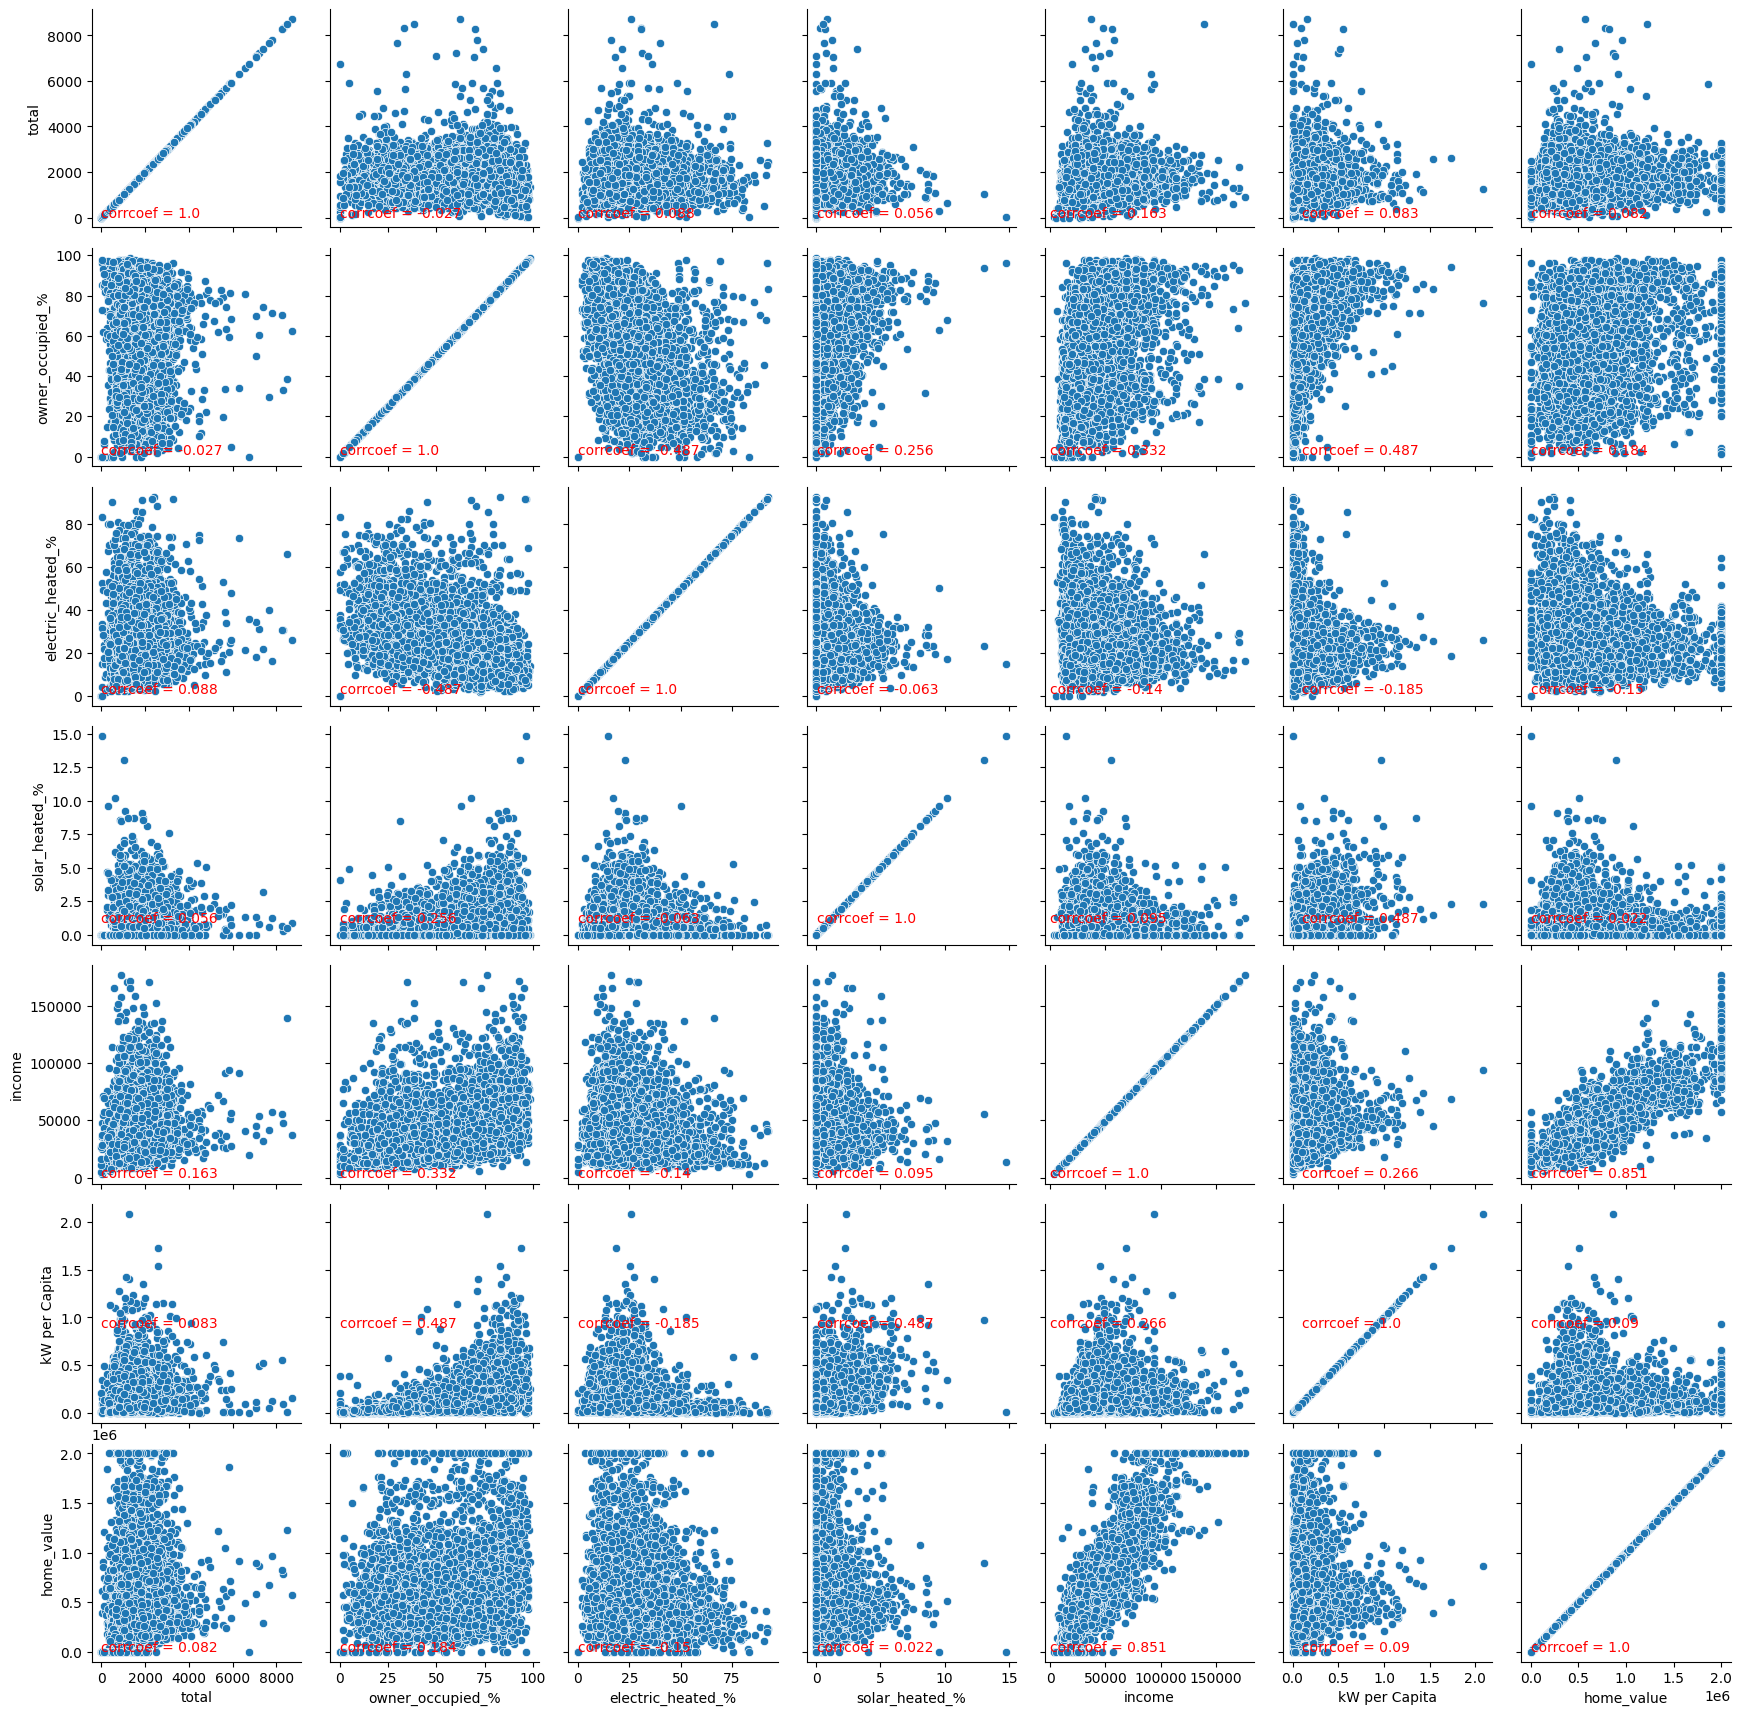

In [18]:
grid = sns.PairGrid(final[['total','owner_occupied_%','electric_heated_%','solar_heated_%','income','kW per Capita','home_value']]) 
grid.map(sns.scatterplot)


def corrfunc(x, y, **kws):
    r = np.round(np.corrcoef(x, y)[0][1], 3)
    ax = plt.gca()
    ax.annotate(f'corrcoef = {r}',
                xy=(.1, .9), color='Red')
grid.map(corrfunc)

# Cluster Analysis 2

In [67]:
SJ_tenure = products.ACS(2019).from_place('San Jose, CA',level='tract',
                                        variables=['B25003'])
SJ_tenure = SJ_tenure.rename(columns={'B25003_002E':'Owner Occupied', 'B25003_003E':'Renter Occupied','B25003_001E':'Total',})

Matched: San Jose, CA to San Jose city within layer Incorporated Places


C:\Users\blake\AppData\Local\Temp\ipykernel_72020\3688783784.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  SJ_tenure = products.ACS(2019).from_place('San Jose, CA',level='tract',


In [37]:
SJ_income = products.ACS(2019).from_place('San Jose, CA',level='tract',
                                        variables=['B19301'])
SJ_income = SJ_income.rename(columns={'B19301_001E':'Estimated Per Capita Income Past 12 Months'})

Matched: San Jose, CA to San Jose city within layer Incorporated Places


C:\Users\blake\AppData\Local\Temp\ipykernel_72020\2422255006.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  SJ_income = products.ACS(2019).from_place('San Jose, CA',level='tract',


In [39]:
SJ_heating = products.ACS(2019).from_place('San Jose, CA',level='tract',
                                        variables=['B25040'])
SJ_heating = SJ_heating.rename(columns={'B25040_008E':'Solar', 'B25040_001E':'Total','B25040_002E':'Utility Gas','B25040_003E':'Tank Gas','B25040_004E':'Electricity',
                        'B25040_005E':'Kerosene',
                       'B25040_006E':'Coal',
                       'B25040_007E':'Wood',
                       'B25040_009E':'Other',
                       'B25040_010E':'No Fuel',})

Matched: San Jose, CA to San Jose city within layer Incorporated Places


C:\Users\blake\AppData\Local\Temp\ipykernel_72020\461850082.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  SJ_heating = products.ACS(2019).from_place('San Jose, CA',level='tract',


In [42]:
SJ_value = products.ACS(2019).from_place('San Jose, CA',level='tract',
                                        variables=['B25077_001E'])

Matched: San Jose, CA to San Jose city within layer Incorporated Places


C:\Users\blake\AppData\Local\Temp\ipykernel_72020\2465539712.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  SJ_value = products.ACS(2019).from_place('San Jose, CA',level='tract',


In [79]:
SJ_test = pd.DataFrame()
SJ_test['total'] = SJ_tenure['Total']
SJ_test['owner_occupied_%'] = 100*SJ_tenure['Owner Occupied']/SJ_test['total']
SJ_test['electric_heated_%'] = 100*SJ_heating['Electricity']/SJ_test['total']
SJ_test['solar_heated_%'] = 100*SJ_heating['Solar']/SJ_test['total']
SJ_test['income'] = SJ_income['Estimated Per Capita Income Past 12 Months']
SJ_test['home_value'] = SJ_value['B25077_001E']


SJ_pred = model.predict(SJ_test)
SJ_tenure['kW per Capita'] = SJ_pred

Text(89.96526002162052, 0.5, '')

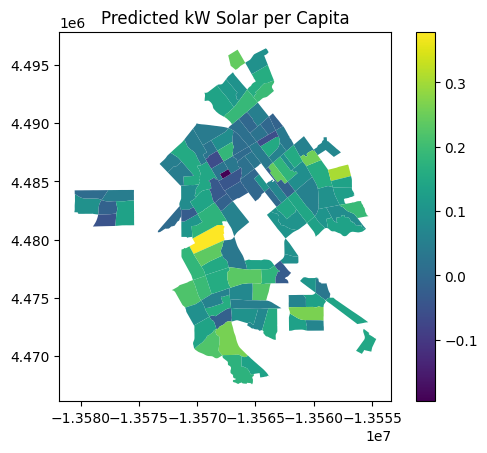

In [107]:
SJ_tenure.plot('kW per Capita', cmap='viridis',legend=True)
plt.title('Predicted kW Solar per Capita')
plt.xlabel('')
plt.ylabel('')

In [55]:
SJ_tenure['GEOID'] = SJ_tenure['GEOID'].str.slice(start=1)
SJ_tenure['GEOID'] = SJ_tenure['GEOID'].astype(str)
joined = newd.set_index("GEOID").join(SJ_tenure.set_index("GEOID"), on='GEOID', how='right')
joined

,GEOID,Unnamed: 0,Utility Service Territory,*,Imperial Irr. District,Palo Alto Utilities,PG&E,SCE,SDG&E,SMUD,...,B25003I_001E,B25003I_002E,B25003I_003E,Total,Owner Occupied,Renter Occupied,state,county,tract,kW per Capita
6085506305,6085506305,Census Tract,6085506305,0.0,0.0,0.0,0.032,0.0,0.0,0.0,...,656.0,80.0,576.0,2412.0,485.0,1927.0,06,085,506305,-0.048645
6085501102,6085501102,Census Tract,6085501102,0.0,0.0,0.0,0.066,0.0,0.0,0.0,...,619.0,360.0,259.0,1335.0,889.0,446.0,06,085,501102,0.087153
6085504320,6085504320,Census Tract,6085504320,0.0,0.0,0.0,0.131,0.0,0.0,0.0,...,65.0,47.0,18.0,837.0,667.0,170.0,06,085,504320,0.240556
6085501401,6085501401,Census Tract,6085501401,0.0,0.0,0.0,0.016,0.0,0.0,0.0,...,537.0,124.0,413.0,1047.0,344.0,703.0,06,085,501401,0.009196
6085503105,6085503105,Census Tract,6085503105,0.0,0.0,0.0,0.028,0.0,0.0,0.0,...,155.0,31.0,124.0,762.0,215.0,547.0,06,085,503105,-0.002608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085503213,6085503213,Census Tract,6085503213,0.0,0.0,0.0,0.041,0.0,0.0,0.0,...,317.0,242.0,75.0,1271.0,874.0,397.0,06,085,503213,0.101231
6085503304,6085503304,Census Tract,6085503304,0.0,0.0,0.0,0.031,0.0,0.0,0.0,...,557.0,188.0,369.0,1832.0,996.0,836.0,06,085,503304,0.144941
6085512036,6085512036,Census Tract,6085512036,0.0,0.0,0.0,0.119,0.0,0.0,0.0,...,295.0,68.0,227.0,1892.0,690.0,1202.0,06,085,512036,0.066893
6085503333,6085503333,Census Tract,6085503333,0.0,0.0,0.0,0.225,0.0,0.0,0.0,...,261.0,181.0,80.0,1350.0,1167.0,183.0,06,085,503333,0.135892


Text(0.5, 1.0, 'kW Solar per Capita San Jose')

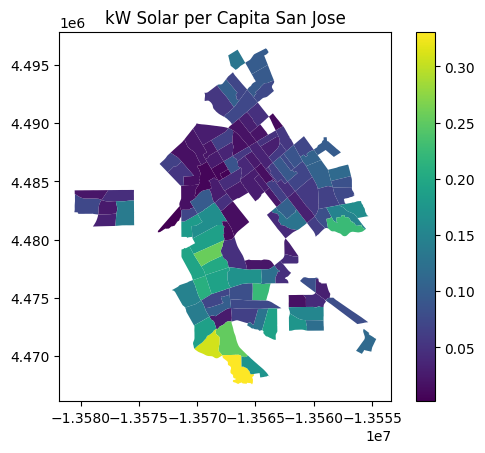

In [77]:
SJ_tenure['actual'] = list(joined['total'])
SJ_tenure.plot('actual',cmap='viridis',legend=True)
plt.title('kW Solar per Capita San Jose')

In [178]:
full = SJ_tenure.copy()
full['kW per Capita'] = full['kW per Capita'].fillna(0)
full['actual'] = full['actual'].fillna(0)

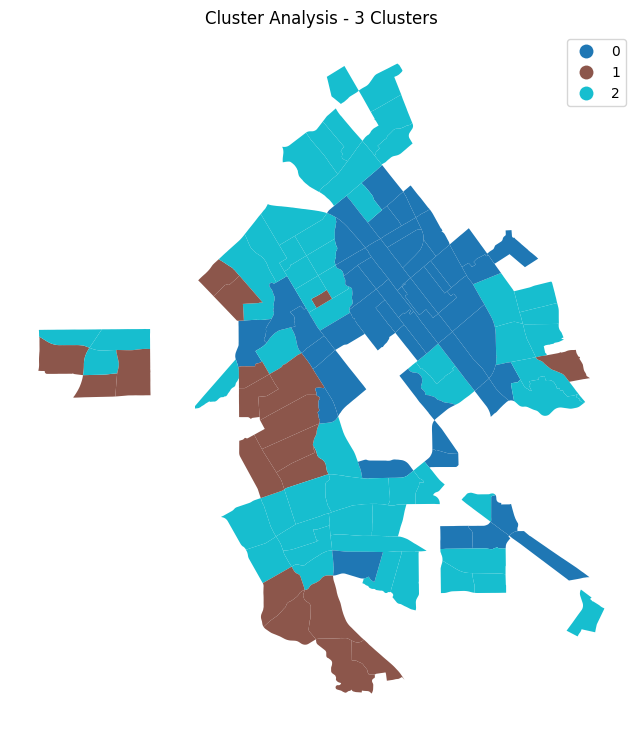

In [179]:
k3 = KMeans(n_clusters=3)
full['total_homes'] =SJ_test['total']
full['owner_occupied_%'] =SJ_test['owner_occupied_%'].fillna(0) 
full['electric_heated_%'] =SJ_test['electric_heated_%'].fillna(0) 
full['solar_heated_%'] =SJ_test['solar_heated_%'].fillna(0)
full['income'] =SJ_test['income'].fillna(0)
full['home_value'] = SJ_test['home_value'].fillna(0) 


cluster_variables = ['total_homes','owner_occupied_%','electric_heated_%','solar_heated_%','income','kW per Capita','home_value']

clust3 = k3.fit(full[cluster_variables])
full['clust3'] = clust3.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
full.plot(
    column='clust3', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title('Cluster Analysis - 3 Clusters')
plt.show()

In [180]:
k3 = full.groupby('clust3')[cluster_variables].mean()
k3.T.round(2)

clust3,0,1,2
total_homes,1294.98,1665.32,1708.54
owner_occupied_%,47.32,65.54,57.87
electric_heated_%,40.42,25.90,34.77
solar_heated_%,0.55,0.49,0.68
income,28393.94,66995.11,45447.19
kW per Capita,0.07,0.13,0.11
home_value,537856.25,1208521.05,839405.56


Text(0.5, 0, '$ Income')

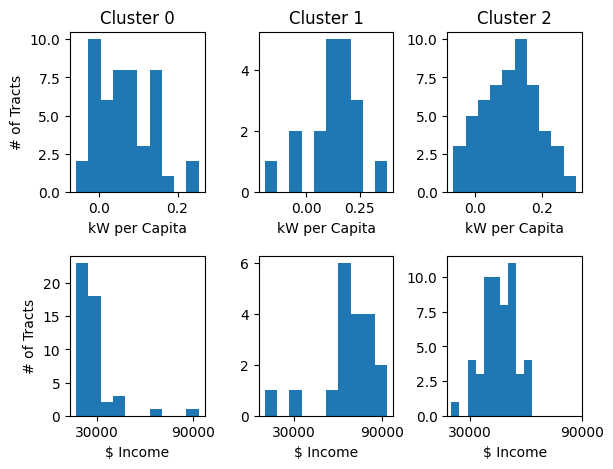

In [196]:
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.subplot(2,3,1)
plt.hist(full[full['clust3']==0]['kW per Capita'])
plt.title("Cluster 0")
plt.ylabel('# of Tracts')
plt.xlabel('kW per Capita')
plt.subplot(2,3,2)
plt.hist(full[full['clust3']==1]['kW per Capita'])
plt.xlabel('kW per Capita')
plt.title("Cluster 1")
plt.subplot(2,3,3)
plt.hist(full[full['clust3']==2]['kW per Capita'])
plt.xlabel('kW per Capita')
plt.title("Cluster 2")



plt.subplot(2,3,4)
plt.hist(full[full['clust3']==0]['income'])
plt.xticks(np.arange(30000,150000, 60000))
plt.ylabel('# of Tracts')
plt.xlabel('$ Income')
plt.subplot(2,3,5)
plt.hist(full[full['clust3']==1]['income'])
plt.xticks(np.arange(30000,150000, 60000))
plt.xlabel('$ Income')
plt.subplot(2,3,6)
plt.hist(full[full['clust3']==2]['income'])
plt.xticks(np.arange(30000,150000, 60000))
plt.xlabel('$ Income')